# **Deep Research with Bing Search**

This notebook demonstrates an agentic research workflow that leverages Azure AI services to conduct comprehensive web-based research on any topic. The workflow includes:

1. **Research Planning** - Breaking down complex queries into structured subtopics and targeted search queries
2. **Information Retrieval** - Using Bing Search API through Azure AI Services to gather relevant web content
3. **Content Analysis** - Summarizing search results and extracting key insights 
4. **Report Generation** - Creating detailed research reports with proper citations
5. **Peer Review** - Evaluating report quality and suggesting improvements until quality standards are met

The notebook orchestrates multiple specialized AI agents working together:
- PlannerAgent - Creates comprehensive research plans with subtopics and queries
- BingSearchAgent - Retrieves relevant search results from the web
- SummaryAgent - Extracts key insights from retrieved content
- ResearchAgent - Compiles findings into structured research reports
- PeerReviewAgent - Provides quality feedback in a continuous improvement loop

Built with Azure OpenAI, Azure AI Projects, and the OpenAI Agents SDK.

## Environment Setup

First, we'll set up our environment by importing necessary libraries and loading environment variables from a .env file. These environment variables contain configuration details such as API keys and endpoints for the Azure OpenAI and Bing Search services.

In [1]:
import os
import dotenv

dotenv.load_dotenv(".env", override=True)

True

### Configure Azure OpenAI to work with OpenAI Agents SDK

In [2]:
from agents import (
    set_default_openai_client,
    set_tracing_disabled,
    OpenAIChatCompletionsModel
)

# setup settings
from openai import AsyncAzureOpenAI
import nest_asyncio
nest_asyncio.apply()

# Use the synchronous client instead of the async one
openai_client = AsyncAzureOpenAI(
    azure_endpoint=os.getenv("AOAI_ENDPOINT"),
    api_key=os.getenv("AOAI_KEY"),
    api_version=os.environ.get("AOAI_API_VERSION", "2024-02-01")
)

# Configure SDK
set_default_openai_client(openai_client)
set_tracing_disabled(True)

reasoningModel = OpenAIChatCompletionsModel(
    model=os.getenv("reasoningModel"), 
    openai_client=openai_client
)

chatModel = OpenAIChatCompletionsModel(
    model=os.getenv("chatModel"),
    openai_client=openai_client
)

## Data Models for Research Workflow

The following Pydantic models define the structured data used throughout our research process:

1. **ResearchTask** - Represents an individual research task with specific search queries
2. **ResearchPlan** - Contains the overall plan with research objectives and tasks
3. **Citation** - Stores source information for proper attribution
4. **ComprehensiveResearchReport** - Defines the structure of the final research output
5. **PeerReviewFeedback** - Contains structured feedback on report quality

In [3]:
from typing import List, Optional
from pydantic import BaseModel, Field

class ResearchTask(BaseModel):
    id: Optional[str] = Field(None, description="Unique identifier for the task")
    subtopic: str = Field(..., description="Subtopic to research")
    search_queries: List[str] = Field(..., description="List of search queries to explore this subtopic")
    completed: bool = Field(..., description="Status of task completion")

class ResearchPlan(BaseModel):
    query: str = Field(..., description="The original user query that prompted this research")
    objective: str = Field(..., description="The overall research objective, clearly defined")
    success_criteria: List[str] = Field(..., description="Criteria to determine when the research is sufficiently complete.")
    related_topics: List[str] = Field(..., description="List of related topics that may be useful for the research.")
    research_tasks: List[ResearchTask] = Field(..., description="List of specific research tasks to complete. Each task focuses on a subtopic.")

class Citation(BaseModel):
    title: str
    url: str

class ComprehensiveResearchReport(BaseModel):
    objective: str = Field(..., description="The original research objective")
    research_report: str = Field(..., description=(
        "Comprehensive research report in markdown. "
        "It should be structured with meaningful headings and subsections, but emphasize **fully-developed paragraphs**. "
        "It should be long and detailed, and it should fully addresses the objectives, "
        "and the various subtopics required to achieve the success criteria. "
        "Use bullet points or lists **only** when they genuinely improve clarity (e.g., summarizing key data). "
        "Tables and other data visualizations are encouraged. "
        "The research report should always be long and detailed.\n\n" 
        "For citations, please use the IEEE (Institute of Electrical and Electronics Engineers). "
        "How it works:\n\n"
        "   1. In the text, use numbered citations in brackets [1].\n"
        "   2. At the end of the report, provide a list of citations in the format "
        "(the list should ONLY contain the sources used in the free text of the research report. "
        "Do NOT list sources which are not cited in the free text of the research report.):\n\n"
        "       [1] Title of the source, URL."
    ))
    citations: List[Citation] = Field(..., description=(
        "List of citations (title and URL), corresponding to references actually used in research_report. "
        "Do not add references that are not cited within the text."
    ))
    identified_gaps: Optional[List[str]] = Field(default=None, description="Identified information gaps.")
    additional_queries: Optional[List[str]] = Field(default=None, description="Suggestions for additional research.")

class PeerReviewFeedback(BaseModel):
    overall_feedback: str = Field(..., description="General feedback on the report.")
    strengths: List[str] = Field(..., description="Aspects of the report that are well done.")
    suggested_improvements: List[str] = Field(..., description="Specific suggestions to improve clarity, completeness, accuracy, or structure.")
    additional_queries: Optional[List[str]] = Field(default=None, description="Additional research queries that could strengthen the report.")
    is_satisfactory: bool = Field(..., description="Indicates if the report meets all quality standards and no further revisions are needed.")
    

## Agent Configuration

The research workflow is powered by two types of agents:

1. **Azure AI Agents** - Created using Azure AI Projects for web search capabilities
2. **OpenAI Agents** - For specialized research tasks

Let's configure each type of agent with their specific instructions and capabilities.

### Azure AI Foundry Connections

First, we'll establish connections to Azure AI Projects, which provides the infrastructure for our Bing Search agent.

In [4]:
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential

project_client = AIProjectClient.from_connection_string(
    credential=DefaultAzureCredential(),
    conn_str=os.environ["PROJECT_CONNECTION_STRING"],
)

The following cell will ***create*** an **Azure AI Agent**, so you only need to run this cell **once**.

In [ ]:
# from azure.ai.projects.models import BingGroundingTool

# bing_connection = project_client.connections.get(
#     connection_name=os.environ["BING_CONNECTION_NAME"]
# )

# bing_tool = BingGroundingTool(connection_id=bing_connection.id)

# bing_search_agent = project_client.agents.create_agent(
#     name="BingSearchAgentScorerV2",
#     description="Agent to perform web searches using Bing.",
#     model="gpt-4o",
#     temperature=0.5,
#     tools=bing_tool.definitions,
#     instructions="""You are a helpful research assistant. 
# Use your available tools (like Bing web search) to find information relevant to the user's query.
# When you use information from a search result in your answer, please cite the source clearly using the tool's citation capabilities.
# Provide a comprehensive answer based on the search results."""
# )

**OpenAI Agents**

In [6]:
from agents import (
    Agent,
    ModelSettings
)

chatModelSettings=ModelSettings(
        max_tokens=32768,
        temperature=0.3,
    )

planner_agent = Agent(
    name="PlannerAgent",
    instructions="""
    You are an expert research planner specializing in creating detailed research plans
    Your task is to analyze a user's research query and create a structured research plan.
    with the following components:
    
    1. DOMAIN CLASSIFICATION:
       Classify the query into a fitting domain (e.g., technology, business, etc.).
       The Domain is not included in the output, but it is important for the other components in the research plan.
       The domain should be a single word (e.g., technology, business, etc.).
       
    2. RESEARCH OBJECTIVE:
       Create a clear, comprehensive objective statement for the research
       
    3. SUBTOPICS:
       Generate relevant subtopics that should be explored to thoroughly answer the query (Important. generate no less than 5 subtopics)
       
    4. SEARCH QUERIES:
       For each subtopic, provide search queries that will yield valuable results (Important. It's better to generate more queries than less queries, but at least 3 queries per subtopic)
       
    5. SUCCESS CRITERIA:
       List the criteria that will determine when the research is complete (Important. generate no less than 4 success criteria)
       Take all of the above into account (e.g., the domain, objective, subtopics, and search queries) to create the success criteria.
       
    6. RELATED TOPICS:
       suggest related topics that may be useful for the research (Important. generate no less than 3 related topics)
    
    Ensure each subtopic is thorough and directly relevant to the research query.
    The search queries should be specific enough to return high-quality results.
    """,
    model=chatModel,
    output_type=ResearchPlan,
    model_settings=chatModelSettings
)

summary_agent = Agent(
    name="SummaryAgent",
    instructions=(
        "You are a comprehensive research summarization specialist. Your task is to **synthesize information from combined search result content** related to a specific subtopic (which will be mentioned in the input prompt). "
        "Create a **single, coherent, detailed, and information-rich summary** that:\n\n"
        "1. Extracts ALL important facts, statistics, findings, and insights **relevant to the specified subtopic** from the combined text.\n"
        "2. Preserves specific numbers, percentages, dates, and technical details whenever present.\n"
        "3. Includes industry-specific terminology and concepts that add depth to the research.\n"
        "4. **Synthesizes** the key arguments and conclusions from the provided sources. If sources present different perspectives or data, try to capture that nuance.\n"
        "5. Provides thorough explanations rather than superficial overviews, integrating information smoothly.\n"
        "6. For technical content, preserves methodologies, technical specifications, and implementation details.\n"
        "7. For comparative content, maintains all sides of the comparison with their specific attributes.\n\n"

        "**Acknowledge that the input combines information potentially from multiple search results.** Your goal is to create a unified summary focused on the overall subtopic, not just list summaries of individual parts.\n\n"

        "Remember that your summary serves as the foundation for generating a comprehensive research report. The quality and depth of the final research report depends directly on how comprehensive and well-synthesized your summary is. Ensure it captures the essence of all provided content relevant to the subtopic.\n\n"

        "FORMAT YOUR SUMMARY AS:\n"
        "## Key Insights\n"
        "- [Most critical takeaway #1]\n"
        "- [Most critical takeaway #2]\n"
        "- [Most critical takeaway #3]\n"
        "- [Optional: Most critical takeaway #4]\n\n"
        "## Extensive Synthesis\n"
        "Write a thorough, multi-paragraph synthesis that:\n"
        "- Integrates all important facts, statistics, findings, and insights relevant to the subtopic.\n"
        "- Preserves specific numbers, percentages, dates, and technical details.\n"
        "- Explains methodologies, technical specifications, and implementation details where relevant.\n"
        "- Highlights agreements, disagreements, and nuances between sources.\n"
        "- Uses industry-specific terminology and concepts.\n"
        "- Provides context, background, and implications for the findings.\n"
        "- Maintains logical flow: start with an overview, then go into specifics, and conclude with implications or open questions."
    ),
    model=chatModel,
    output_type=str,
    model_settings=chatModelSettings
)

research_agent = Agent(
    name="ResearchAgent",
    instructions=(
        "## General Instructions\n"
        "You are a meticulous research analyst specializing in creating **long, comprehensive, authoritative** reports. "
        "Your goal is to produce **in-depth, highly detailed** content that thoroughly analyzes all aspects of the research topic. "
        "Furthermore, you must also demonstrate subject matter expertise with nuanced insights, technical details, and sophisticated analysis.\n\n"
        
        "### Style & Format:\n"
        "- **Default to paragraphs.** Present your findings in cohesive, well-structured paragraphs rather than excessive bullet points.\n"
        "- **Use bullet points sparingly.** Only use them when they add genuine clarity—e.g., summarizing key data.\n"
        "- **Structure** the report with a clear hierarchy, but avoid excessive nesting. Aim for a balanced structure:\n"
        "   - Use main sections and occasional subsections where needed.\n"
        "   - Avoid over-fragmentation by limiting sub-subsections unless absolutely necessary.\n"
        "   - Favor broader thematic groupings to maintain narrative flow and reduce section clutter.\n"
        "   - With that said, if a subtopic would benefit from a sub-subsection, feel free to add it.\n"
        "- **Data visualizations** (e.g., tables, charts, diagrams) in Markdown are encouraged wherever they enhance understanding.\n"
        "- Maintain a logical, flowing structure so each subsection builds upon the prior sections.\n"
        "- **Citations:** Use IEEE style: [1], [2], etc. Provide a 'References' section at the end of your report with only the sources cited in the text.\n\n"
        
        "### Long & Comprehensive Requirement:\n"
        "- The final report must be the equivalent of **10 to 12 pages** of substantive text, approximately **7000-9000 words**.\n"
        "- Each major section should have **extensive exploration** (ideally 800-1000 words per section).\n"
        "- Ensure thorough coverage of the topic with **well-developed paragraphs**, plenty of detail, and rigorous analysis.\n\n"
        
        "### Depth Requirements:\n"
        "- Include **quantitative data**, statistics, and specific examples to support your arguments.\n"
        "- Compare and contrast **multiple perspectives** on complex topics.\n"
        "- Integrate ideas across sections for a cohesive, synthesized analysis rather than isolated observations.\n\n"
        
        "### Workflow\n"
        "- When given the research objective and content, develop a **long-form narrative** with detailed explanations.\n"
        "- If PeerReviewAgent provides feedback, revise thoroughly, addressing all points.\n"
        "- Once feedback is marked satisfactory, present the final report.\n\n"
        
        "### Important Guidelines\n"
        "- Retain high-quality content in any revision.\n"
        "- If feedback highlights missing info, propose specific research queries.\n"
        "- Avoid unnecessary repetition.\n\n"

        "**REMINDER**:"
        "Your output should be a single, cohesive Markdown document that reads like a well-developed academic or professional paper, with minimal use of bullet points. "
        "Prefer broader thematic sections over excessive fragmentation. "
        "Sub-subsections may be used where helpful, but structure should remain balanced and readable. "
        "Lastly, do not forget to include the references section at the end of the report."
    ),
    model=chatModel,
    model_settings=chatModelSettings,
    output_type=ComprehensiveResearchReport,
)

peer_review_agent = Agent(
    name="PeerReviewAgent",
    instructions=(
        "You are a critical yet constructive peer reviewer evaluating research reports. "
        "Your goal is to provide detailed, actionable feedback using a structured evaluation framework.\n\n"
        
        "## Evaluation Framework:\n"
        "1. COMPLETENESS (0-10): Does the report thoroughly cover all aspects of the research topic?\n"
        "   - Are all required subtopics adequately addressed?\n"
        "   - Is there sufficient depth in each section (500+ words per major section)?\n"
        "   - Are there any obvious gaps or missing perspectives?\n\n"
        
        "2. CLARITY & STRUCTURE (0-10): Is the report well-organized and clearly written?\n"
        "   - Does it have a logical flow with clear sections and subsections?\n"
        "   - Are complex concepts explained in accessible language?\n"
        "   - Does it use formatting effectively (headings, lists, tables)?\n\n"
        
        "3. EVIDENCE & SUPPORT (0-10): Is information well-supported?\n"
        "   - Are claims backed by data, statistics, or authoritative sources?\n"
        "   - Are citations used appropriately and consistently?\n"
        "   - Does it include multiple perspectives when appropriate?\n\n"
        
        "4. ANALYSIS & INSIGHT (0-10): Does the report provide valuable analysis?\n"
        "   - Does it go beyond summarizing to provide meaningful insights?\n"
        "   - Does it connect ideas across different sections?\n"
        "   - Does it identify implications and future directions?\n\n"
        
        "## Response Guidelines:\n"
        "- For each criterion, provide a score (0-10) and specific feedback citing examples from the report\n"
        "- In your overall assessment, calculate a total score (0-40)\n"
        "- Reports scoring 32+ (80%) can be marked as satisfactory\n"
        "- For reports below 32, provide clear, prioritized improvement suggestions\n"
        "- Be constructive and specific - point to exact sections that need improvement\n"
        
        "\n\n## Important Rules:"
        "\n- If the report meets all quality standards (score ≥32), simply confirm this by changing the is_satisfactory field to true and hand it back to ResearchAgent."
        "\n- Always perform a handoff to ResearchAgent for final report generation."
    ),
    model=chatModel,
    model_settings=chatModelSettings,
    output_type=PeerReviewFeedback,
)

**hand-offs**

In [7]:
research_agent.handoffs = [peer_review_agent]
peer_review_agent.handoffs = [research_agent]

## Research Workflow

Our system uses specialized AI agents to transform a user query into a comprehensive research report through these steps:

### Process Flow

1. **User Query** → User submits research topic or question
2. **Planning** → PlannerAgent develops structured research plan with objectives and subtopics
3. **Information Retrieval** → BingSearchAgent executes targeted web searches for each area
4. **Analysis** → SummaryAgent processes results, extracting key insights while preserving technical details
5. **Synthesis** → ResearchAgent creates well-structured report with proper citations
6. **Quality Control** → PeerReviewAgent evaluates report for completeness, clarity, and evidence
7. **Revision** → If needed, research report undergoes improvement cycles based on feedback
8. **Delivery** → Final comprehensive, high-quality report delivered to user

This collaborative approach combines the strengths of different specialized agents to produce thorough, evidence-based research that meets predefined quality standards.

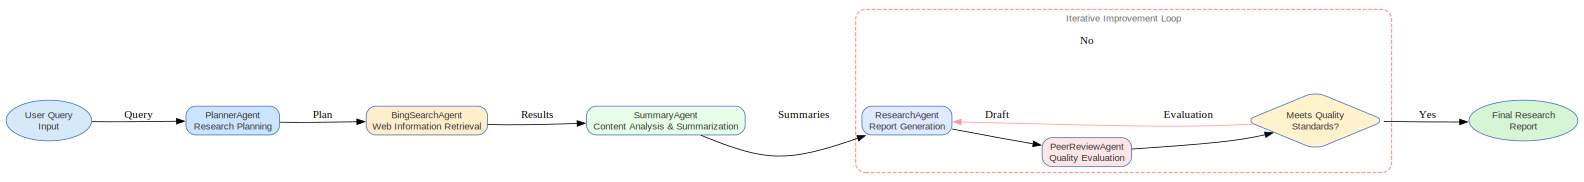

In [8]:
# How to use the module
from common.helper import create_research_workflow_diagram

# This will generate research_workflow_diagram.png and return the Digraph object
workflow_diagram = create_research_workflow_diagram()
workflow_diagram

Let's start with a sample research query.

In [9]:
user_query="What's the latest news in the field of AI? And what big industries will be affected by it?"

### Step 1: Research Planning

The PlannerAgent analyzes the research query and creates a structured plan with:

- Research objective - A clear statement of what the research aims to accomplish
- Subtopics - Key areas to explore for comprehensive coverage
- Search queries - Specific queries for each subtopic to gather relevant information
- Success criteria - Metrics to determine research completeness
- Related topics - Additional areas that may provide valuable context

In [10]:
from agents import Runner

plan = await Runner().run(
    starting_agent=planner_agent,
    input=user_query
)

In [11]:
plan.final_output.research_tasks[0].search_queries

['latest AI breakthroughs 2024',
 'recent advancements in artificial intelligence',
 'AI news June 2024',
 'cutting-edge AI research papers 2024',
 'top AI conferences 2024 highlights']

### Step 2: Information Retrieval

The BingSearchAgent executes web searches for each query in our research plan. For each subtopic:

1. We send multiple search queries to gather diverse perspectives
2. The agent returns structured search results with titles, full_text, and URLs
3. Results are organized by subtopic for further processing

This step leverages Azure AI Projects with Bing Search integration to ensure up-to-date information from across the web.

In [19]:
import os
from tqdm import tqdm

from common.utils_search import extract_agent_response_and_urls


bing_search_agent = project_client.agents.get_agent(agent_id=os.getenv("bingSearchAgentScorerV2ID"))

search_results = []

for subtopic in tqdm(plan.final_output.research_tasks, desc="Subtopics"):
    subtopic_results = {"subtopic": subtopic.subtopic, "queries": []}

    for query in tqdm(subtopic.search_queries, desc=f"Queries ({subtopic.subtopic})", leave=False):
        formatted_query = f"""
        Research the following query: {query}
        This is related to subtopic: {subtopic.subtopic}
        Please provide the information and cite your sources using the available tools.
        """
        try:
            thread = project_client.agents.create_thread()
            message = project_client.agents.create_message(
                thread_id=thread.id,
                role="user",
                content=formatted_query,
            )

            # Process the run
            run = project_client.agents.create_and_process_run(
                thread_id=thread.id,
                agent_id=bing_search_agent.id
            )

            agent_response_text, extracted_urls = extract_agent_response_and_urls(project_client, thread.id, query)

            # Add to our results collection
            subtopic_results["queries"].append({
                "query": query,
                "agent_response": agent_response_text,
                "results": extracted_urls
            })

            # Delete the thread after processing
            project_client.agents.delete_thread(thread_id=thread.id)

        except Exception as e:
            print(f"An error occurred processing query '{query}': {e}")
            # Optionally add error information to results
            subtopic_results["queries"].append({
                "query": query,
                "results": [],
                "error": str(e)
            })

    search_results.append(subtopic_results)

Subtopics: 100%|██████████| 7/7 [05:16<00:00, 45.22s/it]


In [13]:
print(f"Planned total search queries: {sum(1 for task in plan.final_output.research_tasks for search_query in task.search_queries)}\n")
print(f"Actually total search queries: {sum(1 for task in search_results for result in task['queries'])}\n")

Planned total search queries: 29

Actually total search queries: 29



### Step 3: Content Analysis and Summarization

For each search result retrieved, the SummaryAgent:

1. Extracts key facts, statistics, and insights from the raw search content
2. Preserves important technical details, dates, and domain-specific terminology
3. Formats the summary with key insights and detailed paragraph explanations
4. Tracks citations for proper attribution in the final report

This step transforms raw search data into structured, information-rich summaries that will form the basis of our research report.

In [ ]:
from common.utils_summary import collect_responses_and_citations

mapped_chunks = []

for subtopic_result in tqdm(search_results, desc="Summarizing subtopics"):
    all_agent_responses_for_subtopic, unique_citations_for_subtopic = collect_responses_and_citations(subtopic_result)

    # --- Summarize the combined agent responses ONCE per subtopic ---
    content_to_summarize = "\n\n---\n\n".join(all_agent_responses_for_subtopic)

    subtopic_summary = "No content found to summarize for this subtopic." # Default value
    if content_to_summarize:
        summary_prompt = f"Summarize the following information related to the subtopic '{subtopic_result.get('subtopic', 'Unknown Subtopic')}':\n\n{content_to_summarize}"
        try:
            summary_response = await Runner().run(
                starting_agent=summary_agent,
                input=summary_prompt
            )
            subtopic_summary = summary_response.final_output # Adjust based on actual response structure
        except Exception as e:
            print(f"Error summarizing subtopic '{subtopic_result.get('subtopic', 'Unknown Subtopic')}': {e}")
            subtopic_summary = f"Error during summarization for subtopic '{subtopic_result.get('subtopic', 'Unknown Subtopic')}'. Details: {e}"
            # Depending on requirements, you might want to raise the exception, log it, or handle it differently

    # --- Convert set of tuples back to list of dictionaries (or Citation objects) ---
    citations_list = [
        {"title": title, "url": url}
        for title, url in unique_citations_for_subtopic
    ]

    # --- Append the consolidated result ---
    mapped_chunks.append({
        "subtopic": subtopic_result.get("subtopic", "Unknown Subtopic"), # Use .get for safety
        "summary": subtopic_summary,
        "citations": citations_list
    })

Summarizing subtopics: 100%|██████████| 7/7 [02:23<00:00, 20.52s/it]


### Step 4: Report Generation and Peer Review

In this final stage:

1. The ResearchAgent synthesizes all summarized content into a comprehensive report
2. The PeerReviewAgent evaluates the report based on completeness, clarity, evidence, and insight
3. If needed, the report is revised based on feedback
4. This cycle continues until quality standards are met

The final report is structured as a cohesive academic-style document with proper citations and a references section.

In [15]:
import json
from common.utils_research import preprocess_research_data

research_input = preprocess_research_data(plan, mapped_chunks)
research_input_prompt = json.dumps(research_input, indent=2)

final_answer = await Runner().run(
    starting_agent=research_agent,
    input=(
        "Create an exceptionally comprehensive, **paragraph-focused** and detailed research report "
        "using the following content. **Minimize bullet points** and ensure the final text resembles "
        "a cohesive, academic-style paper:\n\n"
        f"{research_input_prompt}\n\n"
        "As a final reminder, don't forget to include the citation list at the end of the report."
    ),
    max_turns=21 # 5 turns are needed for a full collaboration between ResearchAgent and PeerReviewAgent
)

### Extracting the Final Research Report

After the ResearchAgent and PeerReviewAgent complete their collaborative process, we extract the final research report from the agent outputs. The report includes:

1. A clearly defined research objective
2. Multiple sections covering all identified subtopics
3. In-depth analysis with facts, statistics, and insights
4. Proper citations using IEEE format
5. A comprehensive references section

In [ ]:
from agents import HandoffCallItem
import json

def extract_research_report(final_answer):
    # If final output is from ResearchAgent, get the report directly
    if hasattr(final_answer.final_output, "research_report"):
        return final_answer.final_output.research_report
    
    # If final output is from PeerReviewAgent, find the latest research report from ResearchAgent
    for item in reversed(final_answer.new_items):  # Start from end to get the latest
        if isinstance(item, HandoffCallItem) and item.agent.name == "ResearchAgent":
            try:
                args = json.loads(item.raw_item.arguments)
                if "research_report" in args:
                    return args["research_report"]
            except (json.JSONDecodeError, AttributeError):
                continue
    
    # If we couldn't find a report
    raise ValueError("No research report found in the conversation history")

research_report = extract_research_report(final_answer)

### Final Report Presentation

The completed research report is displayed below in Markdown format. The report represents a comprehensive analysis of the original query, incorporating insights from multiple web sources and structured in an academic format with proper citations.

In [17]:
from IPython.display import display, Markdown
display(Markdown(research_report))

# The State of Artificial Intelligence: Recent Breakthroughs and Industry Transformations (2024–2025)

## Introduction

Artificial intelligence (AI) continues to redefine the boundaries of technological innovation and societal transformation. In the period spanning 2024 to early 2025, the pace of AI development has accelerated dramatically, with new models, computational paradigms, and applications emerging at a rate unprecedented in the history of computing. This report provides an in-depth, comprehensive analysis of the latest breakthroughs in AI, synthesizes their implications across major industries, and critically examines the opportunities and challenges associated with widespread AI adoption. Drawing on recent research, expert commentary, and market forecasts, the report aims to offer a holistic view of the evolving AI landscape, with particular attention to the sectors most profoundly affected by these advancements.

## 1. Recent Breakthroughs and News in Artificial Intelligence

### 1.1. The Evolution of Large Language Models and Multimodal AI

The last twelve months have witnessed the release of several landmark AI models, most notably OpenAI's GPT-4o and GPT-4.5, as well as Google's Gemini 2.0. These models represent a significant leap in both scale and capability, particularly in their ability to process and integrate multiple modalities—text, images, and audio—within a single contextual framework. GPT-4o, for example, set a new standard for contextual understanding and multimodal reasoning, enabling applications that range from sophisticated conversational agents to advanced data analysis tools. Its successor, GPT-4.5, introduced in early 2025, further refined these capabilities, with substantial improvements in error reduction, contextual nuance, and emotional intelligence. The result is a new generation of AI systems that interact with users in ways that are increasingly indistinguishable from human communication, supporting applications in customer service, creative writing, and beyond [2][5].

Google's Gemini 2.0, meanwhile, has emerged as a formidable competitor in the multimodal AI space. With its expansive token capacity and architecture optimized for heterogeneous data streams, Gemini 2.0 excels at tasks requiring simultaneous analysis of text, images, and audio. Its advanced functionalities—such as real-time text-to-speech and image generation—have positioned it as a preferred platform for enterprise solutions, creative industries, and research environments [7].

### 1.2. The Synergy of Quantum Computing and AI

A parallel and equally transformative trend is the integration of quantum computing with AI. Google's Willow Quantum Chip exemplifies this convergence, delivering unprecedented computational speed and improved error correction. By harnessing quantum parallelism, the Willow chip enhances the efficiency of AI algorithms, particularly in domains that require high-dimensional data processing, such as drug discovery, cryptography, and complex systems modeling. This fusion is expected to unlock solutions to problems previously considered intractable, marking a paradigm shift in computational science [10].

### 1.3. The Rise of Generative AI and Its Expanding Role

Generative AI models, underpinned by advances in transformer architectures and diffusion models, have rapidly evolved to produce highly realistic media, personalized content, and even scientific hypotheses. These models are now central to industries such as entertainment, marketing, and education, enabling the creation of human-like text, imagery, and audio. Notably, generative AI is also being leveraged in scientific research, where it accelerates hypothesis generation and data synthesis, thereby expediting discovery processes [4][11].

### 1.4. AI Safety, Ethics, and Regulatory Frameworks

As AI systems grow more powerful and ubiquitous, the importance of ethical considerations and regulatory oversight has become paramount. Governments and organizations worldwide are developing frameworks to ensure transparency, fairness, and accountability in AI deployment. These efforts seek to mitigate risks such as algorithmic bias, privacy violations, and unintended societal consequences. The ongoing dialogue around AI safety is shaping the trajectory of research and deployment, ensuring that technological progress is aligned with societal values [3][12].

### 1.5. Research Frontiers: Optimization, Embodiment, and Neuroscience

The research community continues to drive innovation in AI, as evidenced by the cutting-edge work presented at the International Conference on Machine Learning (ICML) 2024. Award-winning papers addressed challenges in neural network optimization, embodied multimodal AI, and the intersection of AI with neuroscience and reinforcement learning. Emerging topics include instruction-guided visual masking, decision-making in embodied agents, and the development of more interpretable and robust AI systems [1][6][8].

### 1.6. Timeline of Major Developments (2024–2025)

| Date         | Development                                      | Organization      |
|--------------|--------------------------------------------------|-------------------|
| Q1 2024      | Release of OpenAI GPT-4o                         | OpenAI            |
| Q2 2024      | Launch of Google Gemini 2.0                      | Google            |
| Q3 2024      | Introduction of Willow Quantum Chip              | Google            |
| Q4 2024      | ICML 2024: Breakthroughs in AI Safety, Embodiment| Research Community|
| Q1 2025      | Release of OpenAI GPT-4.5                        | OpenAI            |

This timeline underscores the rapid cadence of innovation and the growing interplay between foundational research and commercial deployment [2][7][10].

## 2. Industries Most Affected by AI

### 2.1. Overview of Industry Impact

AI's transformative influence is being felt across a broad spectrum of industries, with healthcare, finance, manufacturing, retail, energy, cybersecurity, and education standing out as the most profoundly affected. The impact of AI in these sectors is multifaceted, ranging from operational improvements and cost reductions to the creation of entirely new business models and value propositions. While the core benefits—efficiency, innovation, and improved outcomes—are shared, each industry leverages AI in domain-specific ways, reshaping traditional practices and competitive dynamics [13][14][15].

### 2.2. Comparative Impact Assessment

To illustrate the breadth and depth of AI's influence, the following table provides a comparative assessment of AI applications across major industries:

| Industry      | Key AI Applications                  | Principal Benefits            | Emerging Challenges            |
|---------------|--------------------------------------|-------------------------------|-------------------------------|
| Healthcare    | Diagnostics, personalized medicine,  | Improved accuracy, efficiency,| Data privacy, ethical use,     |
|               | drug discovery, operational automation| patient outcomes              | regulatory compliance          |
| Finance       | Fraud detection, risk assessment,    | Enhanced security, efficiency,| Data bias, transparency,       |
|               | customer service, investment strategy| customer experience           | regulatory adaptation          |
| Manufacturing | Predictive maintenance, quality      | Reduced downtime, higher      | Workforce displacement,        |
|               | control, robotics, process optimization| productivity, cost savings   | integration complexity         |
| Retail        | Hyper-personalization, dynamic       | Increased sales, customer     | Data privacy, algorithmic bias |
|               | pricing, inventory management, AR    | engagement, efficiency        |                               |
| Transportation| Autonomous vehicles, traffic         | Safety, efficiency,           | Regulatory hurdles,            |
|               | management, predictive maintenance   | sustainability                | cybersecurity                  |

This matrix highlights both the opportunities and the sector-specific challenges that accompany AI adoption [13][14][15][16].

### 2.3. Expert Opinions and Market Forecasts

Industry analysts and market research firms forecast that AI will continue to drive exponential growth and innovation across these sectors. For example, the integration of AI in banking alone is projected to influence over $450 billion in revenue by 2025, while the automotive AI market is expected to experience double-digit annual growth rates through the end of the decade. Experts emphasize that the most successful organizations will be those that not only adopt AI technologies but also invest in workforce reskilling, ethical governance, and robust data infrastructure [16][17].

## 3. AI Applications in Finance

### 3.1. Fraud Detection and Security

One of the most critical applications of AI in finance is fraud detection. AI-powered systems leverage machine learning algorithms to monitor transactions in real time, identifying anomalous patterns that may indicate fraudulent activity. These systems are capable of adapting to evolving threats, including sophisticated scams and deepfakes, by continuously learning from new data. The result is a significant reduction in financial losses and enhanced regulatory compliance, as well as increased customer trust in the security of financial transactions [18][19][20].

### 3.2. Customer Service and Personalization

AI-driven chatbots and virtual assistants have revolutionized customer service in banking and financial services. These systems provide 24/7 support, efficiently handling a wide range of customer inquiries and resolving issues with minimal human intervention. By analyzing customer behavior and preferences, AI enables highly personalized financial products and advice, further enhancing client satisfaction and loyalty [21][22].

### 3.3. Risk Management and Credit Assessment

In risk management, AI models process large, complex datasets—including transaction histories, market trends, and alternative data sources—to assess creditworthiness and market risks with greater accuracy than traditional methods. This data-driven approach enables more informed lending decisions, reduces loan defaults, and supports compliance with regulatory requirements [23][24].

### 3.4. Investment Strategies and Operational Efficiency

AI is also transforming investment management through the automation of portfolio optimization, trading, and asset allocation. Machine learning and predictive analytics facilitate real-time asset rebalancing, trend forecasting, and compliance with Environmental, Social, and Governance (ESG) criteria. Operationally, AI automates routine tasks such as document processing and transaction verification, streamlining workflows and reducing costs [25][26][27].

### 3.5. Economic Impact and Future Trends

The economic impact of AI in finance is profound, with projections indicating that AI integration will influence over $450 billion in revenue by 2025. As generative AI becomes increasingly central to fraud detection and risk assessment, financial institutions are expected to further invest in AI-driven innovation. However, the rapid adoption of AI also raises important considerations regarding data privacy, ethical use, and the need for ongoing regulatory adaptation [28][29][30].

## 4. AI Applications in Manufacturing and Supply Chain

### 4.1. Predictive Maintenance and Quality Control

AI has become indispensable in manufacturing, particularly in predictive maintenance and quality control. Machine learning algorithms analyze real-time sensor data from industrial equipment to predict failures before they occur, minimizing unplanned downtime and reducing maintenance costs. Computer vision systems powered by AI detect defects and anomalies in products on the assembly line, ensuring consistently high product standards and reducing the incidence of costly recalls [31][32].

### 4.2. Process Optimization and Smart Factories

AI-driven process optimization enhances manufacturing efficiency by analyzing operational data to identify bottlenecks, streamline workflows, and minimize waste. The advent of AI-powered robotics, including collaborative robots (cobots), has ushered in a new era of automation. These robots work alongside human operators, handling repetitive or hazardous tasks while maintaining high safety standards. Smart factories, underpinned by AI, are capable of autonomous operations, adapting production schedules in response to real-time market demand [33][34].

### 4.3. Supply Chain Management and Logistics

In supply chain management, AI applications are equally transformative. Demand forecasting models predict market trends and customer needs with high accuracy, enabling companies to optimize inventory levels and reduce stockouts or overstock situations. Logistics optimization algorithms improve route planning and delivery scheduling, resulting in lower transportation costs and faster delivery times. AI-driven risk management tools monitor supply chain networks for potential disruptions and recommend mitigation strategies to maintain continuity [35][36].

### 4.4. Opportunities and Challenges

The integration of AI in manufacturing and supply chain management fosters a culture of continuous improvement and innovation. However, it also presents challenges related to workforce displacement, integration complexity, and the need for robust cybersecurity measures. Organizations must balance the benefits of automation with investments in workforce reskilling and change management to ensure sustainable adoption [37][38].

## 5. AI Applications in Retail and E-Commerce

### 5.1. Hyper-Personalization and Customer Engagement

AI is fundamentally transforming retail and e-commerce by enabling hyper-personalization, dynamic pricing, and predictive analytics. AI systems analyze vast datasets—including purchase history and browsing patterns—to generate tailored product recommendations and targeted promotions. This data-driven approach increases customer engagement, satisfaction, and loyalty, while boosting conversion rates and sales [39][40].

### 5.2. AI Shopping Assistants and Augmented Reality

AI-powered shopping assistants, such as voice-activated platforms, enhance the customer journey by providing real-time product suggestions and facilitating seamless transactions. Augmented reality (AR) tools, powered by AI, allow shoppers to visualize products in their own environment before making a purchase, bridging the gap between online and offline shopping and reducing return rates [41][42].

### 5.3. Dynamic Pricing and Inventory Management

AI algorithms enable dynamic pricing by continuously adjusting prices and discounts in response to real-time data on customer behavior, demand fluctuations, and inventory levels. Predictive analytics optimize inventory management, enabling real-time tracking, accurate demand forecasting, and automated replenishment. These capabilities reduce costs, improve responsiveness to market trends, and enhance operational efficiency [43][44].

### 5.4. Data Privacy and Ethical Considerations

The widespread use of AI in retail and e-commerce introduces challenges related to data privacy and ethical AI use. As personalization depends on the collection and analysis of sensitive customer data, retailers must implement robust data protection measures and ensure transparency in AI-driven decision-making processes [45][46].

## 6. AI Applications in Transportation and Automotive

### 6.1. Autonomous Vehicles and Intelligent Traffic Management

AI is at the core of innovations in the transportation and automotive sectors, particularly in the development of autonomous vehicles. AI systems process streams of sensor data in real time to interpret the environment, make complex driving decisions, and execute precise vehicle controls. Intelligent traffic management systems employ machine learning and predictive analytics to monitor and control urban traffic flows, dynamically adjusting signals and routing to alleviate congestion and reduce emissions [47][48].

### 6.2. Predictive Maintenance and Connected Vehicles

Predictive maintenance powered by AI reduces downtime and costs by diagnosing vehicle issues before failures occur. Connected vehicles leverage AI for vehicle-to-everything (V2X) communication, enabling information exchange with infrastructure, other vehicles, and pedestrians. This fosters a coordinated and responsive transportation ecosystem, supporting advanced safety features such as real-time collision detection and avoidance [49][50].

### 6.3. Energy Optimization and Sustainability

AI-driven energy management systems optimize battery usage, manage charging cycles, and predict energy requirements in electric vehicles, extending range and lifespan while supporting sustainability goals. The cumulative impact is a transportation sector that is safer, more reliable, and increasingly sustainable [51][52].

### 6.4. Market Growth and Future Outlook

Industry analyses project significant growth in the automotive AI market, with continued advancements expected in efficiency, safety, and innovation. However, challenges such as regulatory approval, cybersecurity, and public acceptance remain areas for ongoing focus and development [53][54].

## 7. Opportunities and Challenges in AI Adoption

### 7.1. Opportunities

Across all industries, AI offers opportunities for increased efficiency, cost reduction, enhanced customer experience, and the creation of new products and services. The ability to process vast amounts of data, identify patterns, and automate complex tasks is driving innovation and value creation at an unprecedented scale. Organizations that successfully integrate AI into their operations are likely to gain significant competitive advantages in the coming years [13][16][17].

### 7.2. Challenges

Despite these opportunities, the rapid adoption of AI presents several challenges. Ethical concerns, including algorithmic bias, data privacy, and transparency, are at the forefront of public and regulatory discourse. Workforce displacement and the need for reskilling are pressing issues, particularly in sectors where automation threatens traditional job roles. Regulatory frameworks must evolve to keep pace with technological advancements, ensuring that AI systems are deployed responsibly and equitably. Finally, the integration of AI with legacy systems and the management of cybersecurity risks require ongoing investment and vigilance [3][12][45][53].

## Conclusion

The period from 2024 to early 2025 marks a watershed moment in the evolution of artificial intelligence. Breakthroughs in large language models, multimodal AI, and quantum computing are driving profound changes across major industries, from healthcare and finance to manufacturing, retail, and transportation. While the opportunities for innovation and value creation are immense, the challenges associated with ethical use, workforce adaptation, and regulatory oversight are equally significant. As AI continues to reshape the global economy and society, a balanced approach that prioritizes both technological progress and responsible governance will be essential to realizing its full potential.

## References

[1] ICLR 2024 Outstanding Paper Award – Quantum™ Ai Labs, https://quantumailabs.net/iclr-2024-outstanding-paper-award/
[2] GPT-4.5 - Wikipedia, https://en.wikipedia.org/wiki/GPT-4.5
[3] Sora, Gemini 2.0, and the Quantum Chip Willow: AI Closes 2024 ..., https://transparentalgorithm.substack.com/p/sora-gemini-20-and-the-quantum-chip
[4] Beyond Text and Images: Generative AI's Expanding Role in Network Security, https://www.ibtimes.co.in/beyond-text-images-generative-ais-expanding-role-network-security-881970
[5] GPT-4.5: A Game-Changer or Overhyped Interim Model?, https://www.forwardfuture.ai/p/gpt-4-5-a-new-king-on-the-throne
[6] 16 Best AI Research Papers: ICLR 2024 Outstanding Paper Award, https://www.analyticsvidhya.com/blog/2024/05/best-research-papers-on-ai-iclr-outstanding-paper-awards/
[7] Introducing Gemini 2.0: our new AI model for the agentic era - The Keyword, https://blog.google/technology/google-deepmind/google-gemini-ai-update-december-2024/
[8] ICLR 2024 Awards, https://iclr.cc/virtual/2024/awards_detail
[9] The Year Ahead in AI: Generative Tech, Robots, Emerging Risks, https://www.technewsworld.com/story/ai-in-2025-generative-tech-robots-and-emerging-risks-179587.html
[10] Meet Willow, our state-of-the-art quantum chip - The Keyword, https://blog.google/technology/research/google-willow-quantum-chip/
[11] AI in 2024: A Year of Groundbreaking Releases and Shifting Paradigms, https://opentools.ai/news/ai-in-2024-a-year-of-groundbreaking-releases-and-shifting-paradigms
[12] Five Transformative AI Technology Trends Shaping 2025 - Forbes, https://www.forbes.com/councils/forbestechcouncil/2025/04/15/five-transformative-ai-technology-trends-shaping-2025/
[13] 2025 Predictions: How AI Will Transform Healthcare, Finance, and Retail, https://hyperight.com/2025-predictions-how-ai-will-transform-healthcare-finance-and-retail/
[14] AI Revolution in Industries: How AI is Revolutionizing Healthcare ..., https://huffindia.com/ai-revolution-healthcare-finance-education-2025/
[15] Artificial Intelligence: Which Industries Are Being Impacted the Most ..., https://www.customvirtualoffice.com/post/artificial-intelligence-which-industries-are-being-impacted-the-most-by-ai-in-2024
[16] Top Industries Dominating AI: From Finance to Healthcare, https://opentools.ai/news/top-industries-dominating-ai-from-finance-to-healthcare
[17] Top 10 AI Innovations Transforming Industries in 2025, https://tekdino.com/top-10-ai-innovations-transforming-industries-in-2025/
[18] AI in Finance – From Robo-Advisors to Fraud Detection, Trends for 2025, https://appearls.com/ai-in-finance-from-robo-advisors-to-fraud-detection-trends-for-2025/
[19] Adoption of artificial intelligence-based credit risk assessment and ..., https://fbj.springeropen.com/articles/10.1186/s43093-025-00464-3
[20] How AI Is Used in Fraud Detection [2025] - DataDome, https://datadome.co/learning-center/ai-fraud-detection/
[21] The Role of AI in Improving Customer Service, Fraud Detection, and Risk ..., https://ijcttjournal.org/2024/Volume-72%20Issue-9/IJCTT-V72I9P115.pdf
[22] Role of AI in Fraud Detection: Insights for 2025, https://www.bombaysoftwares.com/blog/ai-in-fraud-detection
[23] Fighting fraud in payments with AI - kpmg.com, https://kpmg.com/us/en/articles/2025/fighting-fraud-payments-ai.html
[24] Banking Transformation in 2025: An AI-Powered, Customer-Centric ..., https://www.bankingexchange.com/management-topics/financial-trends/item/10289-banking-transformation-in-2025-an-ai-powered-customer-centric-approach
[25] What Is AI in Banking? How AI Will Change the Industry in 2025, https://www.vonage.com/resources/articles/ai-in-banking/
[26] AI in Banking in 2025: 5 Key Uses & Tools Explained, https://www.edstellar.com/blog/ai-in-banking
[27] Technology Trends in Investment Management to Watch in 2025, https://www.harringtonstarr.com/resources/blog/technology-trends-in-investment-management-to-watch-in-2025/
[28] AI & Banking Fraud Detection: How Institutions Are Fighting Back, https://interface.ai/blog/ai-banking-fraud-detection-institutions-fighting-back-2025/
[29] AI, Payments, and Digital Banking: Fintech Predictions 2025, https://techinformed.com/fintech-predictions-2025-ai-payments-compliance/
[30] AI Revolutionizes Banking: Personalization, Fraud Detection, and Growth ..., https://b2bdaily.com/fintech/ai-revolutionizes-banking-personalization-fraud-detection-and-growth-by-2025/
[31] AI in manufacturing: transforming the industry - alten.com, https://www.alten.com/ai-in-manufacturing-transforming-the-industry/
[32] Revolutionizing Supply Chains: Unleashing the Power of AI-Driven ... - MDPI, https://www.mdpi.com/2078-2489/16/1/26
[33] AI in Manufacturing : Key Use Cases and benefits for 2025 and Beyond, https://www.softlabsgroup.com/blogs/ai-in-manufacturing/
[34] How is AI being used in Manufacturing | IBM, https://www.ibm.com/think/topics/ai-in-manufacturing
[35] Artificial Intelligence in Smart Manufacturing: Emerging Opportunities ..., https://link.springer.com/chapter/10.1007/978-3-031-80154-9_2
[36] Harnessing generative AI in manufacturing and supply chains, https://www.mckinsey.com/capabilities/operations/our-insights/operations-blog/harnessing-generative-ai-in-manufacturing-and-supply-chains
[37] AI in manufacturing: Transforming engineering, production and supply chains, https://blogs.sw.siemens.com/tecnomatix/ai-in-manufacturing-transforming-engineering-production-and-supply-chains/
[38] Artificial intelligence in supply chain management: A systematic ..., https://www.sciencedirect.com/science/article/pii/S014829632030583X
[39] Personalizing Experiences: The Role Of AI In Tailoring Products - Forbes, https://www.forbes.com/councils/forbesbusinesscouncil/2025/04/15/personalizing-experiences-the-role-of-ai-in-tailoring-products/
[40] 2025: The Year the AI Hype Drives Measurable, High Returns in Retail, https://www.mytotalretail.com/article/2025-the-year-the-ai-hype-drives-measurable-high-returns-in-retail/
[41] AI In Ecommerce Inventory Management: What You Need To Know For 2025, https://ecommercefastlane.com/ai-in-ecommerce-inventory-management/
[42] AI in E-commerce: The Ultimate Guide to Growth & Automation, https://www.techrepublic.com/article/ai-in-ecommerce/
[43] 11 Best AI Tools for Inventory Management in 2025 - ddiy.co, https://ddiy.co/best-ai-tools-inventory-management/
[44] Retail, tech experts share AI predictions for 2025, https://www.retailcustomerexperience.com/articles/retail-tech-experts-share-ai-predictions-for-2025/
[45] Impact of AI on Inventory Management: 9 Key Impacts in 2025, https://www.invensis.net/blog/impact-of-ai-on-inventory-management
[46] Agentic AI, Personalized Shopping Will Dominate 2025 - PYMNTS.com, https://www.pymnts.com/artificial-intelligence-2/2024/ai-to-power-personalized-shopping-experiences-in-2025/
[47] AI in Public Transport | UITP, https://www.uitp.org/publications/ai-public-transport/
[48] Future of AI in the Automotive Industry | StartUs Insights, https://www.startus-insights.com/innovators-guide/future-of-ai-in-automotive-industry/
[49] Understanding AI Risks in Transportation - Department of Transportation, https://www.transportation.gov/sites/dot.gov/files/2024-09/HASS_COE_AI_Assurance_Whitepaper_AI_Risk_Sep2024.pdf
[50] Generative AI Is Coming To The Transportation Industry-Is It ... - Forbes, https://www.forbes.com/sites/timothypapandreou/2024/03/04/generative-ai-is-coming-to-the-transportation-industry-is-it-ready/
[51] AI in Transportation: 9 Disruptive Use Cases [2024 Update], https://www.v7labs.com/blog/ai-in-transportation
[52] AI in Transportation: Advancing Mobility Solutions in 2024, https://www.linkedin.com/pulse/ai-transportation-advancing-mobility-solutions-2024-dave-balroop-fkngc
[53] The AI revolution in transportation | ITS International, https://www.itsinternational.com/feature/ai-revolution-transportation
[54] AI in Automotive: A Strategic Guide for Industry Leaders [2025-2030], https://www.startus-insights.com/innovators-guide/ai-in-automotive/

### Research Workflow Visualization

Below we can see the detailed steps in the research and review process, showing how the ResearchAgent and PeerReviewAgent collaborated to produce the final report. This visualization helps us understand how many iterations were required to meet quality standards.

In [18]:
from common.helper import pretty_print_agent_workflow
pretty_print_agent_workflow(final_answer)

🔍 AGENT WORKFLOW: 'Create an exceptionally comprehensive, **paragraph-focused** and detailed research report using the following content. **Minimize bullet points** and ensure the final text resembles a cohesive, academic-style paper:

{
  "objective": "To identify and summarize the latest developments in artificial intelligence (AI) and analyze which major industries are being or will be significantly impacted by these advancements.",
  "aggregated_summaries": [
    {
      "subtopic": "Recent Breakthroughs and News in AI",
      "summary": "## Key Insights\n- 2024 and 2025 have seen major breakthroughs in AI, notably with the release of OpenAI's GPT-4o and GPT-4.5, and Google's Gemini 2.0, each pushing the boundaries of multimodal and contextual AI capabilities.\n- The integration of quantum computing with AI, exemplified by Google\u2019s Willow Quantum Chip, is accelerating computational speed and error correction, opening new frontiers in AI applications.\n- Generative AI models ar